# CAM을 만들고 평가해 보자

## 1. 라이브러리 버전 확인하기

In [1]:
# 라이브러리 불러오기
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

import os
import json
import random

import pandas as pd

print('완료')

완료


In [2]:
# gpu 확인하기
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 불러오기
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
print('완료')

완료


In [4]:
# 데이터셋의 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인하기
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [5]:
# 데이터셋의 클래스 수
num_classes = ds_info.features["label"].num_classes
print(num_classes)

120


In [6]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# VGG19 모델 불러오기
base_model = VGG19(
    include_top=False,         # Fully Connected Layer 제거
    weights='imagenet',        # ImageNet 사전 학습된 가중치 사용
    input_shape=(224, 224, 3)  # 입력 이미지 크기
)

# Global Average Pooling 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax', use_bias=False)(x)

# 새로운 모델 생성
vgg19_model = Model(inputs=base_model.input, outputs=outputs)

# 모델 요약 출력 (필요 시)
vgg19_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
def normalize_and_resize_img(image, label):
    # 이미지 데이터 정규화 및 크기 조정
    image = tf.image.resize(image, [224, 224])  # 이미지를 224x224 크기로 조정
    image = tf.cast(image, tf.float32) / 255.0  # uint8(0~255) 데이터를 float32(0~1)로 정규화
    return image, label  # 정규화된 이미지와 레이블을 반환

print("완료")

완료


In [8]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    # 데이터셋에 정규화 및 배치 처리 적용
    ds = ds.map(
        normalize_and_resize_img,  # 데이터셋의 각 이미지를 정규화 및 크기 조정
        num_parallel_calls=2       # 병렬로 데이터를 2개의 코어에서 처리
    )
    ds = ds.map(
        onehot,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)      # 지정된 크기만큼 배치로 묶음
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터 로드와 학습을 병렬 처리하여 성능 최적화
    return ds  # 처리된 데이터셋 반환

print('완료')

완료


In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16, 120)


In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.getenv('HOME')+'/class_activation_map/vgg19_2_model_checkpoint.h5', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

In [12]:
# 학습하기
vgg19_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_vgg19_model_2 = vgg19_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/2
750/750 [==============================] - 235s 301ms/step - loss: 4.7920 - accuracy: 0.0074 - val_loss: 4.7863 - val_accuracy: 0.0140

Epoch 00001: val_loss improved from inf to 4.78628, saving model to /aiffel/class_activation_map/vgg19_2_model_checkpoint.h5
750/750 [==============================] - 228s 303ms/step - loss: 4.7872 - accuracy: 0.0087 - val_loss: 4.7840 - val_accuracy: 0.0140

Epoch 00002: val_loss improved from 4.78628 to 4.78404, saving model to /aiffel/class_activation_map/vgg19_2_model_checkpoint.h5


In [14]:
vgg19_model.save_weights(os.getenv('HOME')+'/class_activation_map/vgg19_2_model_weights.h5')

In [15]:
vgg19_model.save(os.getenv('HOME')+'/class_activation_map/vgg19_2_model.keras')

In [17]:
with open('history/history_resnet50.json', 'w') as f:
    pd.DataFrame(history_vgg19_model_2.history).to_json(f)

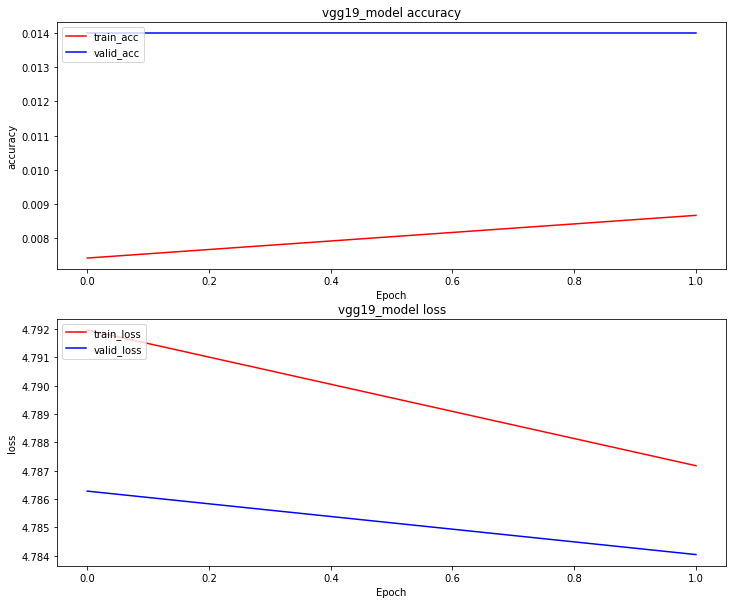

In [18]:
## 모델 결과 시각화
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_vgg19_model_2.history['accuracy'], 'r', label="train_acc")
plt.plot(history_vgg19_model_2.history['val_accuracy'], 'b', label="valid_acc")
plt.title('vgg19_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_vgg19_model_2.history['loss'], 'r', label="train_loss")
plt.plot(history_vgg19_model_2.history['val_loss'], 'b', label="valid_loss")
plt.title('vgg19_model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [20]:
val_acc_loss_dict = {'No Augmentation': history_vgg19_model_2.history['val_accuracy'],
                     'No Augmentation': history_vgg19_model_2.history['val_loss']}
df1 = pd.DataFrame(val_acc_loss_dict)
df1

,No Augmentation
0,4.786279
1,4.784040
